# 1)- Introduction

- The momentum trading strategy consists of creating buying/selling signals based on various time framed sum moving averages (SMA) of an asset's price action or volume (2-days MA, 3-weeks MA, etc..). In general, we follow the momentum of the price action by buying low and selling high.

- Just like the ARIMA notebook, we are going to conduct our data analytics using AAPL stock over this year so far. The financial data is from YahooFinance package.

**PS: The trading volume is the quantity of an asset exchanged within the last 24h, it's generally expressed in dollars.**


# 2)- How are algorithmic trading strategies developed?

- **First**, we collect and clean our data.

- **Secondly**, we use a development backtester (in our case, it'll be the backtrader package) to identify potentially profitable correlations and behaviours in the data.

- After we rank these behaviours from most promising to least, we validate the best ones using our previously defined backtester.

But before continuing, let's dive into **Backtesting**:

- A classic **Backtesting** starts with a time series of historical asset prices that is divided into two series: a training series A (70% of the data), and a testing series B (30% of the data). We start by training our model using **the data from the training window**, and then we apply that model **on data from the testing window** to monitor its performance using metrics like **Sharpe ratio, Calmar ratio, P&L, etc..**

- After training our model, if performance in the backtest is negative or extremly weak we abandon the strategy and start over. In the other hand, if the strategy's performance in period B meets or even exceeds period A results, then we are ready to either go live with our strategy, which is a bit risky, or more commonly **paper trade the strategy** for a while with live data.

In [ ]:
!pip install yfinance pandas-ta backtrader

     |████████████████████████████████| 115 kB 9.8 MB/s 
     |████████████████████████████████| 410 kB 53.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 6.4 MB 54.4 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=868cede770e153d8d55c2ab87e548d168eae8984b2ef363d954ac3c53ae88858
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conf

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas_ta as ta
import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
from IPython.display import display

# 2)- How choose the SMA time frame?

- A critical component of a momentum trading strategy is the choice of the right time frame over which we compute our moving averages. This time frame can determine how successful our strategy will be. 
- First, let's load our AAPL stock data for the year 2021 from YahooFinance:

In [ ]:
aapl = yf.Ticker("AAPL")
df_apple = aapl.history(start="2021-1-1", end="2021-12-31", interval="1d")
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04,132.701914,132.791359,125.983331,128.617096,143301900,0.0,0
2021-01-05,128.100300,130.932844,127.643112,130.207306,97664900,0.0,0
2021-01-06,126.937458,130.247057,125.605665,125.824318,155088000,0.0,0
2021-01-07,127.573531,130.823500,127.076595,130.117844,109578200,0.0,0
2021-01-08,131.618582,131.817369,129.432065,131.240921,105158200,0.0,0


In [ ]:
# Dataset shape
df_apple.shape

(251, 7)

- We can see that the dataset contains only 251 samples, instead of 355. This is because weekends and holidays are not accounted for as trading days. Now that we got the data, let's compute some SMAs over close prices and volumes.
- We will also have empty values in some first days of the computed moving averages, since there are not enough data to compute over.

In [ ]:
# Let's compute the 5-d, 15-d and 25-d SMA for visualization
df_apple["5d_sma_price"] = df_apple['Close'].rolling(5).mean()
df_apple["15d_sma_price"] = df_apple['Close'].rolling(15).mean()
df_apple["25d_sma_price"] = df_apple['Close'].rolling(25).mean()

# The 25-d SMA for trading volume
df_apple["25d_sma_volume"] = df_apple['Volume'].rolling(25).mean()
df_apple = df_apple[df_apple["25d_sma_price"].notna()]
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,5d_sma_price,15d_sma_price,25d_sma_price,25d_sma_volume
Date,,,,,,,,,,,
2021-02-08,135.398555,136.324246,134.293707,136.274475,71297200,0.0,0,135.246027,135.665578,132.870437,110034488.0
2021-02-09,135.985816,137.239977,135.219401,135.378647,76774200,0.0,0,135.489169,136.221035,133.140899,107373380.0
2021-02-10,135.846472,136.354115,133.776126,134.761536,73046600,0.0,0,135.817609,136.457068,133.323068,106388648.0
2021-02-11,135.269161,135.756892,133.149059,134.502747,64280000,0.0,0,135.408517,136.355158,133.670205,102756328.0
2021-02-12,133.726369,134.900884,133.069429,134.741623,60145100,0.0,0,135.131805,136.123406,133.855157,100779004.0


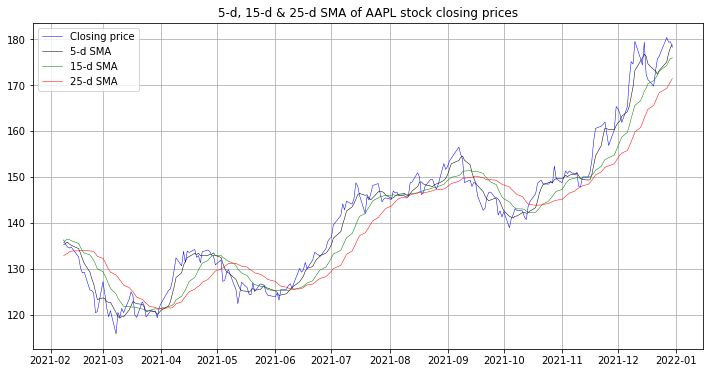

In [ ]:
# Let's visualize the SMAs in a graph
plt.figure(figsize=(12, 6))
plt.plot(df_apple['Close'], color='blue', linewidth=0.5, label='Closing price')
plt.plot(df_apple['5d_sma_price'], color='black', linewidth=0.5, label='5-d SMA')
plt.plot(df_apple['15d_sma_price'], color='green', linewidth=0.5, label='15-d SMA')
plt.plot(df_apple['25d_sma_price'], color='red', linewidth=0.5, label='25-d SMA')
plt.title("5-d, 15-d & 25-d SMA of AAPL stock closing prices")
plt.legend(loc='best')
plt.grid()
plt.show()

# 3)- Creating buy/sell signals

In [ ]:
# Backtesting parameters
data = bt.feeds.PandasData(dataname=yf.download('AAPL', start="2021-1-1", end="2021-12-31", interval="1d"))
startcash = 100000
commission = 0.002
stake = 100

[*********************100%***********************]  1 of 1 completed


In [ ]:
class TradeLogger(bt.analyzers.Analyzer):
    """
    Analyzer returning closed trades information.
    """

    def start(self):
        super(TradeLogger, self).start()

    def create_analysis(self):
        self.rets = []
        self.vals = dict()

    def notify_trade(self, trade):
        """Receives trade notifications before each next cycle"""
        if trade.isclosed:
            self.vals = {'Date': self.strategy.datetime.datetime(),
                         'Gross PnL': round(trade.pnl, 2),
                         'Net PnL': round(trade.pnlcomm, 2),
                         'Trade commission': trade.commission,
                         'Trade duration (in days)': (trade.dtclose - trade.dtopen)
            }
            self.rets.append(self.vals)

    def get_analysis(self):
        return self.rets


def set_and_run(data, strategy, startcash, commission, stake):
    # Initialize cerebro engine, add the strategy and initial capital
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy)
    cerebro.adddata(data)
    cerebro.broker.setcash(startcash)
    print("Starting Portfolio Value: {}".format(cerebro.broker.getvalue()))

    # Set the broker commission
    cerebro.broker.setcommission(commission) 

    # Number of shares to buy/sell
    cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

    # Add evaluation metrics
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, compression=1, factor=365, annualize=True)
    cerebro.addanalyzer(TradeLogger, _name="trade_logger")

    results = cerebro.run()
    print("Final Portfolio Value: {}".format(cerebro.broker.getvalue()))
    print("Sharpe Ratio: {}".format(results[0].analyzers.sharperatio.get_analysis()['sharperatio']))
    display(pd.DataFrame(results[0].analyzers.trade_logger.get_analysis()))

    plt.rcParams['figure.figsize'] = (16, 8)
    fig = cerebro.plot(barupfill=False,
                       bardownfill=False,
                       style='candle',
                       plotdist=0.5, 
                       volume=True,
                       barup='green',
                       valuetags=False,
                       subtxtsize=8)

## 3.1)- First strategy: SMA of close price & trading volume



- After computing the SMAs, we need to establish a strategy based on which we generate a buy or sell signal. The strategy will be as simple as this: when the asset's close price is below the its SMA, and the volume is above the its SMA it's a buying signal, and vice versa for selling.

- Next, we'll backtest the number of days over which we will compute our SMA for close price and volume, we'll finally take the values having the best Sharpe ratio.

In [ ]:
class FirstStrategy(bt.Strategy):
    params = (('close_period', 5),
              ('volume_period', 4)
    )

    def __init__(self):
        self.close_sma = bt.indicators.SMA(self.data.close, period=self.params.close_period)
        self.volume_sma = bt.indicators.SMA(self.data.volume, period=self.params.volume_period)
        
    def next(self):
        if not self.position:
            if self.data.close < self.close_sma and self.data.volume > self.volume_sma:
                self.buy()
        else:
            if self.data.close > self.close_sma and self.data.volume < self.volume_sma: 
                self.sell()

In [ ]:
# Backtesting the model's parameters
cerebro = bt.Cerebro()
cerebro.adddata(data)
strats = cerebro.optstrategy(FirstStrategy,
                             close_period=range(2, 25), 
                             volume_period=range(2, 25))
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission) 
cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
results = cerebro.run()

df_result = pd.DataFrame([{"Close period": result[0].params.close_period, 
                           "Volume period": result[0].params.volume_period,
                           "Sharpe ratio": result[0].analyzers.sharperatio.get_analysis()['sharperatio'], 
                           "Variability weighted return (in %)": result[0].analyzers.vwr.get_analysis()['vwr']
                          } for result in results])
display(df_result.sort_values("Sharpe ratio", ascending=False))

,Close period,Volume period,Sharpe ratio,Variability weighted return (in %)
71,5,4,0.130736,5.115155
94,6,4,0.126631,4.946450
48,4,4,0.115738,4.438497
72,5,5,0.100979,4.157204
73,5,6,0.094093,3.975228
...,...,...,...,...
422,20,10,-0.073789,-1.629633
514,24,10,-0.074222,-1.684503
513,24,9,-0.074222,-1.684503
429,20,17,-0.074799,-1.559862


We see that for a 5d SMA closing price, and 4d SMA volume we obtain the best sharpe ratio.

Starting Portfolio Value: 100000
Final Portfolio Value: 105578.70186920163
Sharpe Ratio: 2.497704443808067


,Date,Gross PnL,Net PnL,Trade commission,Trade duration (in days)
0,2021-01-27,1565.0,1510.76,54.241998,8.0
1,2021-02-05,152.0,97.36,54.636002,7.0
2,2021-03-02,-284.0,-335.93,51.932001,13.0
3,2021-03-10,71.0,22.47,48.534001,5.0
4,2021-03-23,343.0,294.35,48.646001,4.0
5,2021-03-30,-24.0,-72.09,48.092000,4.0
6,2021-04-26,247.0,193.56,53.438000,5.0
7,2021-05-10,-706.0,-759.18,53.176001,11.0
8,2021-05-17,332.0,281.94,50.064000,6.0
9,2021-05-25,259.0,208.39,50.610001,5.0


<IPython.core.display.Javascript object>

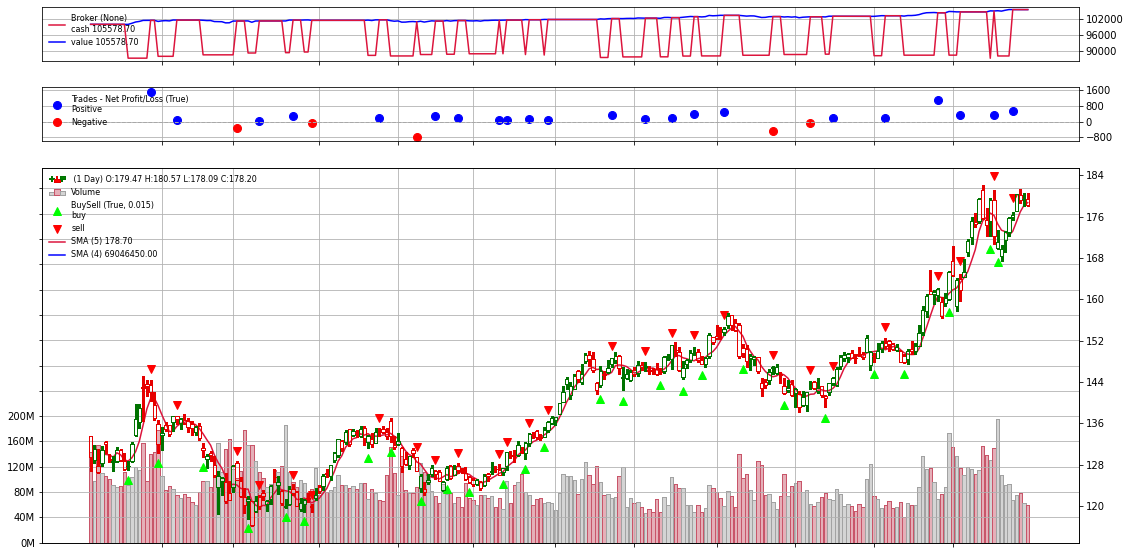

In [ ]:
# Run the strategy & plot the results
set_and_run(data,
            FirstStrategy,
            startcash,
            commission,
            stake)

## 3.2)- Second strategy: Short & long period SMA

- A second strategy would be to create a short period SMA (e.g: 10-d SMA), and a longer one (60-d SMA), and then analyze the crossovers between the two to generate buy/sell signals:

1.   If the short period SMA is below the long period SMA, it means that the trend is going down, so it's a **sell signal**, it's also known as **the death cross**.
2.   Otherwise, the trend is shiftting up, and it's a **buy signal**, it's also called **the golden cross**.





In [ ]:
class SecondStrategy(bt.Strategy):
    params = (('short_period', 6),
              ('long_period', 98)
    )

    def __init__(self):
        self.short_period_sma = bt.indicators.SMA(self.data.close, period=self.params.short_period)
        self.long_period_sma = bt.indicators.SMA(self.data.close, period=self.params.long_period)
        
    def next(self):
        if not self.position:
            if self.short_period_sma > self.long_period_sma:
                self.buy()
        else:
            if self.short_period_sma < self.long_period_sma:
                self.sell()

In [ ]:
# Backtesting the model's parameters
cerebro = bt.Cerebro()
cerebro.adddata(data)
strats = cerebro.optstrategy(SecondStrategy,
                             short_period=range(1, 30), 
                             long_period=range(80, 120))
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission) 
cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
results = cerebro.run()

df_result = pd.DataFrame([{"Short period": result[0].params.short_period, 
                           "Long period": result[0].params.long_period,
                           "Sharpe ratio": result[0].analyzers.sharperatio.get_analysis()['sharperatio'], 
                           "Variability weighted return (in %)": result[0].analyzers.vwr.get_analysis()['vwr']
                          } for result in results])
display(df_result.sort_values("Sharpe ratio", ascending=False))

,Short period,Long period,Sharpe ratio,Variability weighted return (in %)
218,6,98,0.107620,4.602863
74,2,114,0.103871,4.483696
194,5,114,0.103871,4.483696
187,5,107,0.103871,4.483696
188,5,108,0.103871,4.483696
...,...,...,...,...
840,22,80,0.047771,2.613042
800,21,80,0.046648,2.570673
920,24,80,0.045433,2.523594
600,16,80,0.044135,2.462214


- After backtesting the main parameters, we are taking a 6d short period SMA, and a 98d long period SMA for the strategy.

Starting Portfolio Value: 100000
Final Portfolio Value: 104956.14441223144
Sharpe Ratio: 2.056074819088159


,Date,Gross PnL,Net PnL,Trade commission,Trade duration (in days)
0,2021-10-12,1343.0,1288.39,54.606,117.0


<IPython.core.display.Javascript object>

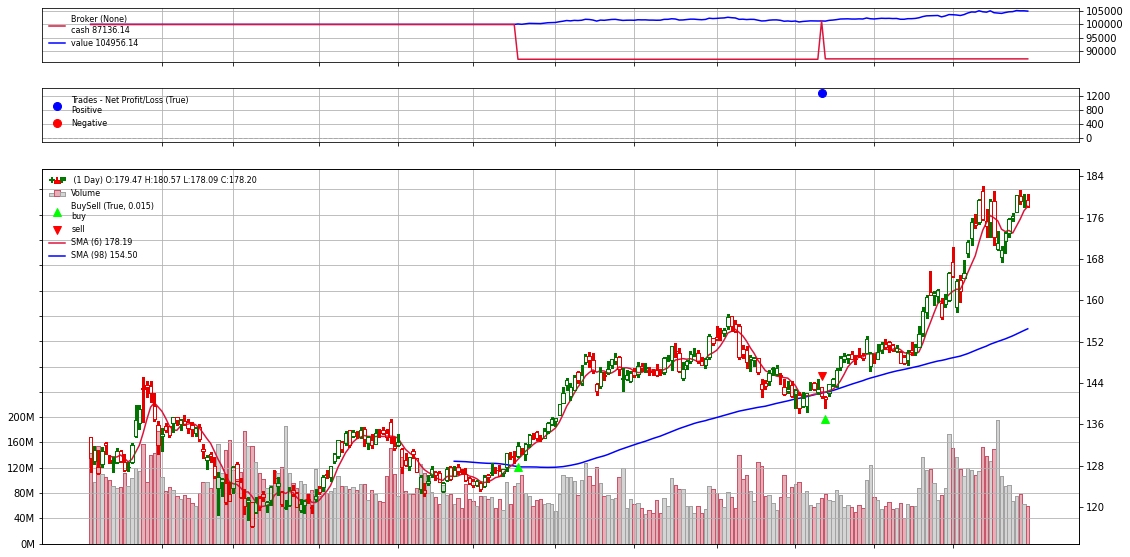

In [ ]:
# Run the strategy & plot the results
set_and_run(data,
            SecondStrategy,
            startcash,
            commission,
            stake)

## 3.3)- Third strategy: The Moving Average Convergence Divergence indicator (MACD)

- **The MACD** is a really famous strategy in algorithmic trading, it's basically a difference between a long term and a short term exponential moving average (EMA). So far, we only covered **SMA** where the mean is computed such as every data point is equally weighted, an **EMA** gives higher weights to recent data points in order to give more importance to recent events in our calculations.

- Now, let's create our main indicators:

1.   Firstly, we'll create the difference between short & long term EMAs called the MACD (We usually take a 26-period EMA for long term, and a 12-period EMA for short term).

2.   Secondly, we'll create an EMA of the MACD itself, which we'll call **The signal** (We usually take a 9-period EMA).

3.   Finally, we'll create a histogram which is basically just the difference between MACD and the signal.



- After creating the indicators, the MACD strategy is as simple as this: When MACD line crosses above the signal, it's a buy, otherwise it's a short.

In [ ]:
class MACDStrategy(bt.Strategy):
    params = (('short_period', 25),
              ('long_period', 51),
              ('signal_period', 9)
    )

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close,
                                       period_me1=self.params.short_period,
                                       period_me2=self.params.long_period,
                                       period_signal=self.params.signal_period)
        
        self.macd_cross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal, plot=True, subplot=True)

    def next(self):
        if not self.position:
            if self.macd_cross > 0:
                self.buy()
        else:
            if self.macd_cross < 0:
                self.sell()

In [ ]:
# Backtesting the model's parameters
cerebro = bt.Cerebro()
cerebro.adddata(data)
strats = cerebro.optstrategy(MACDStrategy,
                             short_period=range(20, 30), 
                             long_period=range(50, 70))
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission) 
cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
results = cerebro.run()

df_result = pd.DataFrame([{"Short period": result[0].params.short_period, 
                           "Long period": result[0].params.long_period,
                           "Sharpe ratio": result[0].analyzers.sharperatio.get_analysis()['sharperatio'], 
                           "Variability weighted return (in %)": result[0].analyzers.vwr.get_analysis()['vwr']
                          } for result in results])
display(df_result.sort_values("Sharpe ratio", ascending=False))

,Short period,Long period,Sharpe ratio,Variability weighted return (in %)
101,25,51,0.109820,4.274694
84,24,54,0.109820,4.274694
83,24,53,0.109820,4.274694
102,25,52,0.108976,4.250248
122,26,52,0.108976,4.250248
...,...,...,...,...
119,25,69,0.083952,3.535306
98,24,68,0.083952,3.535306
197,29,67,0.083515,3.522343
198,29,68,0.083515,3.522343


- After backtesting, we are taking a 25d short period ema, and a 51d long period ema.

Starting Portfolio Value: 100000
Final Portfolio Value: 104565.62358703613
Sharpe Ratio: 2.098103008883807


,Date,Gross PnL,Net PnL,Trade commission,Trade duration (in days)
0,2021-08-04,2074.0,2019.24,54.760001,54.0
1,2021-09-13,-313.0,-373.88,60.878000,10.0


<IPython.core.display.Javascript object>

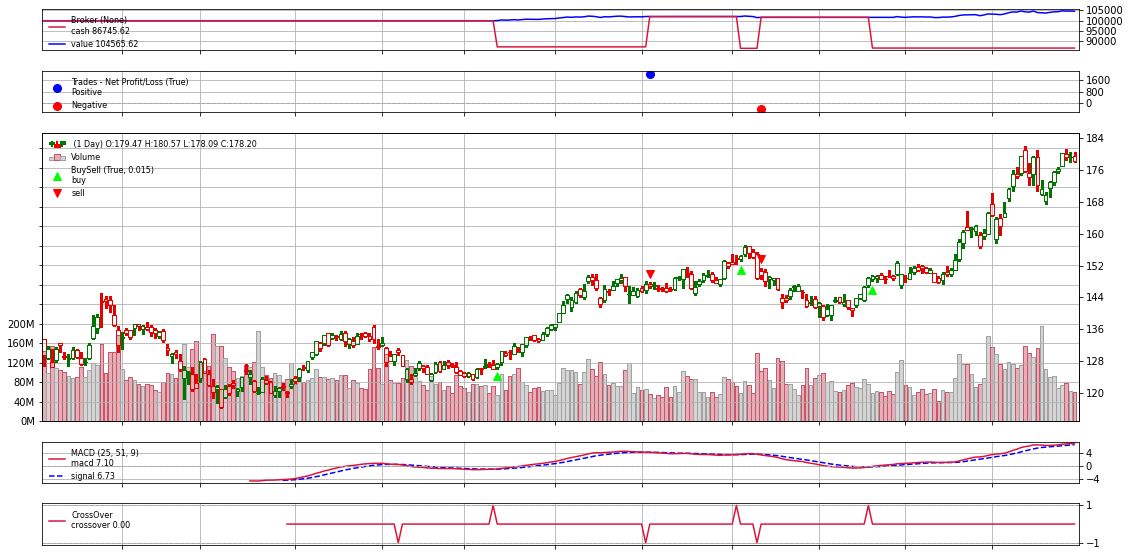

In [ ]:
# Run the strategy & plot the results
set_and_run(data,
            MACDStrategy,
            startcash,
            commission,
            stake)

## 3.4)- Fourth strategy: Bollinger Bands (BB)

- **The Bollinger Bands strategy (BB)** is a widely used trading indicator, which is simple but immensly profitable. It was invented by **John Bollinger** in the **1980s**, and it's basically generating buy/sell signals based on overbought/oversold areas. It comprises of three main components:

1.   **Middle Bollinger Band (MBB)** which is an n-period SMA of the closing price action (usually we take n=20):

$$
\boxed{MBB(PA,n) = SMA(PA,n)}
$$


2.   **Upper Bollinger Band (UBB)** is a line which is m standard deviations above the **MBB** (usually we take m=2):

$$
\boxed{UBB(PA,n,m) = MBB(PA,n) + m∗\sigma(PA,n)}
$$

3.   **Lower Bollinger Band (LBB)** is a line which is m standard deviations below the **MBB**:

$$
\boxed{LBB(PA,n,m) = MBB(PA,n) - m∗\sigma(PA,n)}
$$

- where PA is the price action. Now, let's compute the above indicators for n=20, and m=2.


- Let's implement the **BB** strategy: when the **Close price** goes below the **LBB**, we are taking a long position, and if the **Close price** crosses above the **UBB** we are taking a short position.

In [ ]:
class BollingerBandsStrategy(bt.Strategy):
    params = (('MBB_period', 17),
              ('devfactor', 3)
            )

    def __init__(self):
        self.boll = bt.indicators.BollingerBands(period=self.params.MBB_period, devfactor=self.params.devfactor)

    def next(self):
        if not self.position:
          if self.data.close < self.boll.lines.bot:
             self.buy()
        else:
          if self.data.close > self.boll.lines.top:
            self.sell()

In [ ]:
# Backtesting the MBB period and deviation factor
cerebro = bt.Cerebro()
cerebro.adddata(data)
strats = cerebro.optstrategy(BollingerBandsStrategy,
                             MBB_period=range(5, 30), 
                             devfactor=range(2, 7))
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission) 
cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
results = cerebro.run()

df_result = pd.DataFrame([{"MBB period": result[0].params.MBB_period, 
                           "Deviation factor": result[0].params.devfactor,
                           "Sharpe ratio": result[0].analyzers.sharperatio.get_analysis()['sharperatio'], 
                           "Variability weighted return (in %)": result[0].analyzers.vwr.get_analysis()['vwr']
                          } for result in results])
display(df_result.sort_values("Sharpe ratio", ascending=False))

,MBB period,Deviation factor,Sharpe ratio,Variability weighted return (in %)
61,17,3,0.064202,2.730800
51,15,3,0.064202,2.730800
66,18,3,0.064202,2.730800
56,16,3,0.064202,2.730800
5,6,2,0.029192,1.632764
...,...,...,...,...
119,28,6,NaN,0.000000
121,29,3,NaN,0.000000
122,29,4,NaN,0.000000
123,29,5,NaN,0.000000


- For a 17d MBB and a deviation factor of 3, we are having the highest Sharpe ratio.



Starting Portfolio Value: 100000
Final Portfolio Value: 102787.62969665528
Sharpe Ratio: 1.2265735474188473


,Date,Gross PnL,Net PnL,Trade commission,Trade duration (in days)
0,2021-11-19,2845.0,2787.63,57.369998,198.0


<IPython.core.display.Javascript object>

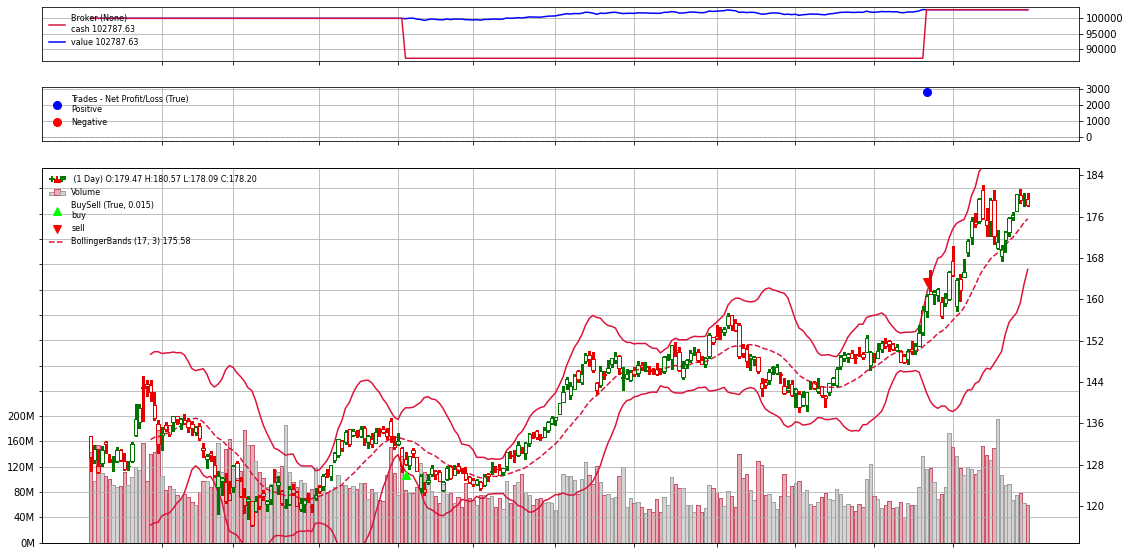

In [ ]:
# Run the strategy & plot the results
set_and_run(data,
            BollingerBandsStrategy,
            startcash,
            commission,
            stake)

## 3.5)- Fifth strategy: The stochastic oscillator

- The stochastic oscillator is **a momentum trading strategy**, that generates overbought/oversold signals, by detecting trend price reversals. It works by computing the variation of price action relative the maximum low-high variation over a period of trading days. It was invented by George Lane in the 1950s, and it's so popular among the trading community due to its ease of explainability and track record of profitability.

- This strategy comprises of two main signals:
 

1. **%K or Fast oscillator** which computes the percentage variation of the actual close price relative the maximum variation recorded over a period of trading days:

$$
\boxed{ \text{%K} = \frac{C - L_{d}}{H_{d} - L_{d}} * 100}
$$


2. **%D or Slow oscillator** which is a 3-d **SMA** of the **%K**, giving a smoother representation of the signal:


$$
\boxed{ \text{%D} = SMA(\text{%K}, 3) }
$$

where: **C** is the close price, $L_{d}$ and $H_{d}$ are respectivly the lowest and the highest price over a period of **d** trading days.


- Let's explain the strategy, and how buy/sell signals will be generated. **%K** is bounded between **0** and **100%**, and we consider that if it crosses above **80%** it's an overbought area hence a sell signal, and when it goes below **20%** or **%K** crosses above **%D** it's an oversold area hence a buy signal.

In [ ]:
class StochasticOscillatorStrategy(bt.Strategy):
    params = (('pk', 10),
              ('pd', 2),
              ('up_percent', 80),
              ('low_percent', 20)
            )

    def __init__(self):
        # Get rolling highest and lowest values over a window
        H = bt.ind.Highest(self.data.close, period=self.params.pk)
        L = bt.ind.Lowest(self.data.close, period=self.params.pk)

        # Compute K & D
        self.l.K = 100 * (self.data.close - L) / (H - L)
        self.l.D = bt.indicators.SMA(self.data.close, period=self.params.pd)

    def next(self):
        if not self.position:
          if self.l.K < self.params.low_percent or self.l.K > self.l.D:
             self.buy()
        else:
          if self.l.K > self.params.up_percent:
            self.sell()

In [ ]:
# Backtesting the MBB period and deviation factor
cerebro = bt.Cerebro()
cerebro.adddata(data)
strats = cerebro.optstrategy(StochasticOscillatorStrategy,
                             pk=range(10, 20), 
                             pd=range(2,7))
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission) 
cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
results = cerebro.run()

df_result = pd.DataFrame([{"Sliding window length for K": result[0].params.pk, 
                           "SMA period for D": result[0].params.pd,
                           "Sharpe ratio": result[0].analyzers.sharperatio.get_analysis()['sharperatio'], 
                           "Variability weighted return (in %)": result[0].analyzers.vwr.get_analysis()['vwr']
                          } for result in results])
display(df_result.sort_values("Sharpe ratio", ascending=False))

,Sliding window length for K,SMA period for D,Sharpe ratio,Variability weighted return (in %)
0,10,2,0.017701,1.324960
1,10,3,0.017701,1.324960
2,10,4,0.017701,1.324960
3,10,5,0.017701,1.324960
4,10,6,0.017701,1.324960
14,12,6,-0.020420,0.021829
13,12,5,-0.020420,0.021829
12,12,4,-0.020420,0.021829
10,12,2,-0.020420,0.021829
11,12,3,-0.020420,0.021829


Starting Portfolio Value: 100000
Final Portfolio Value: 101271.88611755372
Sharpe Ratio: 0.3381680957151692


,Date,Gross PnL,Net PnL,Trade commission,Trade duration (in days)
0,2021-01-21,602.0,549.68,52.316000,2.0
1,2021-03-16,-1060.0,-1112.40,52.400000,40.0
2,2021-04-05,433.0,384.32,48.682001,11.0
3,2021-04-26,267.0,213.60,53.398001,3.0
4,2021-05-25,-422.0,-473.97,51.971999,22.0
5,2021-06-09,213.0,162.54,50.458000,8.0
6,2021-07-26,481.0,422.65,58.346002,6.0
7,2021-08-13,316.0,257.04,58.956000,10.0
8,2021-08-31,763.0,703.46,59.538000,12.0
9,2021-10-12,-740.0,-798.77,58.772000,29.0


<IPython.core.display.Javascript object>

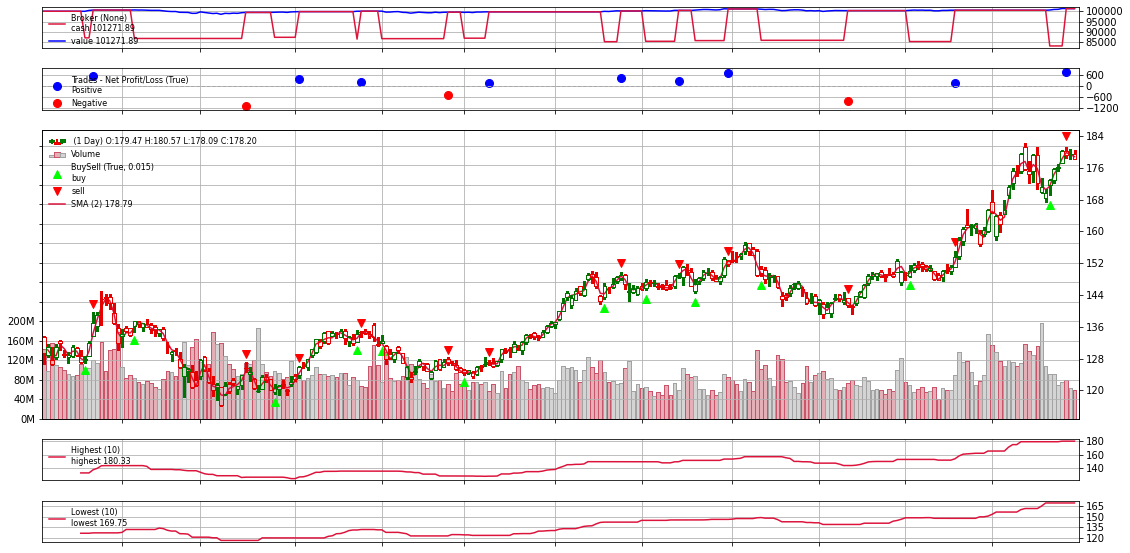

In [ ]:
# Run the strategy & plot the results
set_and_run(data,
            StochasticOscillatorStrategy,
            startcash,
            commission,
            stake)

## 3.6)- Sixth strategy: The KDJ indicator

- **The KDJ indicator** is derived from the stochastic oscillator, and it has the exact same lines mentioned before with **%K** and **%D**, plus one more line called **%J** (hence the name **KDJ**) that measures the divergence between **%K** and **%D**:

$$
\boxed{ \text{%J} = 3 * \text{%K} - 2 * \text{%D}}
$$




In [ ]:
df_apple = aapl.history(start="2021-1-1", end="2021-12-31", interval="1d")

In [ ]:
Ld = df_apple["Low"].rolling(14).min() 
Hd = df_apple["High"].rolling(14).max() 
df_apple["k_percentage"] = (df_apple["Close"] - Ld) * 100 / (Hd - Ld)
df_apple["d_percentage"] = df_apple["k_percentage"].rolling(3).mean() 
df_apple["j_percentage"] = 3 * df_apple["k_percentage"] - 2 * df_apple["d_percentage"]
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,k_percentage,d_percentage,j_percentage
Date,,,,,,,,,,
2021-01-04,132.701930,132.791375,125.983346,128.617111,143301900,0.0,0,NaN,NaN,NaN
2021-01-05,128.100285,130.932829,127.643097,130.207291,97664900,0.0,0,NaN,NaN,NaN
2021-01-06,126.937466,130.247065,125.605672,125.824326,155088000,0.0,0,NaN,NaN,NaN
2021-01-07,127.573546,130.823515,127.076610,130.117859,109578200,0.0,0,NaN,NaN,NaN
2021-01-08,131.618598,131.817384,129.432080,131.240936,105158200,0.0,0,NaN,NaN,NaN


- **The KDJ indicator** generates buy/sell signals based on the values of K, D and J:


1.   If the three values ​​of K, D, and J are below 20 (oversold zone), it's a buy signal.
2.   If the three values ​​of K, D, and J are above 80 (overbought zone), it's a sell signal.
3.   Otherwise, the three values are hovering between 20 and 80, so it's more advisable to wait and see.




In [ ]:
def KDJ(df):
    buy = False    
    buy_signals, sell_signals = [], []

    for key, row in df.iterrows():
        # Buying signal
        if row['k_percentage'] < 15 and row['d_percentage'] < 15 and row['j_percentage'] < 15:
            if buy:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)
            else:
                sell_signals.append(np.nan)
                buy_signals.append(row['Close'])
                buy = True

        # Selling signal
        elif row['k_percentage'] > 80 and row['d_percentage'] > 80 and row['j_percentage'] > 80:
            if buy:
                sell_signals.append(row['Close'])
                buy_signals.append(np.nan)
                buy = False
            else:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)

        # Neutral signal
        else:
            sell_signals.append(np.nan)
            buy_signals.append(np.nan)

    return sell_signals, buy_signals

df_apple["kdj_sell_signals"], df_apple["kdj_buy_signals"] = KDJ(df_apple)
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,k_percentage,d_percentage,j_percentage,kdj_sell_signals,kdj_buy_signals
Date,,,,,,,,,,,,
2021-01-04,132.701930,132.791375,125.983346,128.617111,143301900,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-05,128.100285,130.932829,127.643097,130.207291,97664900,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-06,126.937466,130.247065,125.605672,125.824326,155088000,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-07,127.573546,130.823515,127.076610,130.117859,109578200,0.0,0,NaN,NaN,NaN,NaN,NaN
2021-01-08,131.618598,131.817384,129.432080,131.240936,105158200,0.0,0,NaN,NaN,NaN,NaN,NaN


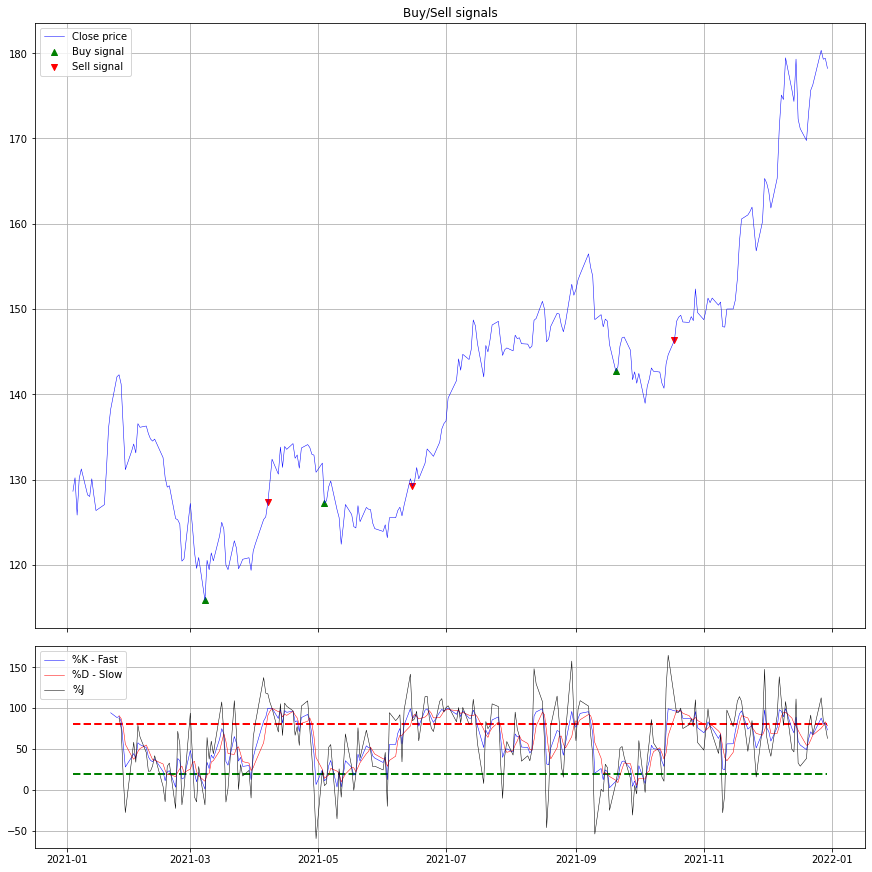

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, constrained_layout=True) 
ax[0].plot(df_apple['Close'] , label='Close price', linewidth=0.5, color='blue')
ax[0].scatter(df_apple.index , df_apple['kdj_buy_signals'], label='Buy signal', marker='^', color='green')
ax[0].scatter(df_apple.index , df_apple['kdj_sell_signals'] , label='Sell signal' , marker='v', color='red')
ax[0].set_title("Buy/Sell signals")
ax[0].legend(loc='best')
ax[0].grid()

ax[1].plot(df_apple['k_percentage'], label='%K - Fast', linewidth=0.5, color='blue')
ax[1].plot(df_apple['d_percentage'], label='%D - Slow', linewidth=0.5, color='red')
ax[1].plot(df_apple['j_percentage'], label='%J', linewidth=0.5, color='black')
ax[1].hlines(y=20, xmin=df_apple.index.min(), xmax=df_apple.index.max(), colors='green', linestyles='--', lw=2)
ax[1].hlines(y=80, xmin=df_apple.index.min(), xmax=df_apple.index.max(), colors='red', linestyles='--', lw=2)
ax[1].legend(loc='best')
ax[1].grid()
plt.show()